## Exercise 2: Opinion Dynamics Models
In this exercise, you will implement two different opinion dynamics models. In part 1, you will implement a simple model, and derive the analytical solution of it. In part 2, you will implement a more realistic and complicated model, and analyze the effects of its different parameters through simulations.  

Let's get started :)  

In [29]:
import random
import numpy as np
from numpy.testing import assert_almost_equal, assert_equal
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
import re
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13.5})

### Part 1: The DeGroot Model (DeGroot 1974)
In part 1, you will implement the DeGroot model from [the DeGroot 1974 paper](https://www.jstor.org/stable/pdf/2285509.pdf?casa_token=y6BU1WKCoSAAAAAA:AHUX3o2QJmCsCk02AD36wwtOBjWiwWkNkwvfGbrdX5J977JMvER9TcQegg_3JQ6eNhmxwGsQtd5T35sE2DyCEoe8fwYNs9lNqUsg7ObRgRK4UEAFZA). The DeGroot model is one of the first opinion dynamics models and serves as the basis of many subsequent models in the literature.

The DeGroot model assumes a simple mechanism. Suppose we have a number of agents (i.e., people) in the system, each with an opinion value that lies between -1 and 1. Then, at each time step, the agents update their opinions according to how much they are influenced by the other agents. 

Formally, let us assume $N$ agents in the system. We represent the opinions of agents as an $N\times 1$ column vector $F$, where $F_i$ is the opinion of agent $i$; and the influence among agents as an $N\times N$ opinion update matrix $P$, where $P_{ij}$ represents how much agent $i$ is influenced by agent $j$, and $\sum_j P_{ij}=1$ (i.e., each row of $P$ sums up to 1). We denote $F^{(t)}$ as the opinion vector at time step $t$, where $F^{(0)}$ is the initial opinion vector. At each time step $t$, the opinion vector is updated by $F^{(t)}=PF^{(t-1)}$.

How does this work intuitively? As an illustrative example, we assume there are 3 agents in the system, who initially have the opinion values of $-\frac{1}{5}$, $\frac{1}{2}$, and $\frac{9}{10}$; therefore 
$$F^{(0)}=\begin{pmatrix}
-\frac{1}{5} \\
\frac{1}{2} \\
\frac{9}{10} \\
\end{pmatrix}.$$ 

We further assume that we have an opinion update matrix 
$$P=\begin{pmatrix}
\frac{2}{3} & \frac{1}{3} & 0 \\
0 & \frac{3}{5} & \frac{2}{5} \\
\frac{1}{4} & 0 & \frac{3}{4} \\
\end{pmatrix}$$
such that $F^{(t)}=PF^{(t-1)}$. As such, the first row $(\frac{2}{3}, \frac{1}{3}, 0)$ of the matrix $P$ means that the opinion of agent 1 at time $t$ is calculated by $\frac{2}{3}$ times the opinion of agent 1 at time $t-1$ plus $\frac{1}{3}$ times the opinion of agent 2 at time $t-1$; or formally, 
$F_1^{(t)}=\frac{2}{3} F_1^{(t-1)} + \frac{1}{3} F_2^{(t-1)}$. Similarly, $F_2^{(t)}=\frac{3}{5} F_2^{(t-1)} + \frac{2}{5} F_3^{(t-1)}$, and $F_3^{(t)}=\frac{1}{4} F_1^{(t-1)} + \frac{3}{4} F_3^{(t-1)}$. 

Following these rules, the opinion vector at time 1 is for example calculated by
$$F^{(1)}=PF^{(0)}=\begin{pmatrix}
\frac{2}{3} & \frac{1}{3} & 0 \\
0 & \frac{3}{5} & \frac{2}{5} \\
\frac{1}{4} & 0 & \frac{3}{4} \\
\end{pmatrix}\begin{pmatrix}
-\frac{1}{5} \\
\frac{1}{2} \\
\frac{9}{10} \\
\end{pmatrix}=\begin{pmatrix}
\frac{2}{3}\cdot(-\frac{1}{5})+\frac{1}{3}\cdot\frac{1}{2} \\
\frac{3}{5}\cdot\frac{1}{2}+\frac{2}{5}\cdot\frac{9}{10} \\
\frac{1}{4}\cdot(-\frac{1}{5})+\frac{3}{4}\cdot\frac{9}{10} \\
\end{pmatrix}=\begin{pmatrix}
\frac{1}{30} \\
\frac{33}{50} \\
\frac{5}{8} \\
\end{pmatrix}.$$


#### Task 1.1: Simulation
In task 1.1, you will complete the code for simulating the opinion evolution process as described above. Specifically, you need to **calculate the opinion vector at the current time step** `F_new` (i.e., $F^{(t)}$), using `P` and the opinion vector at the previous time step `F` (i.e., $F^{(t-1)}$), in the `simulate_degroot` function.

In [30]:
def simulate_degroot(F_init, P, t_max):
    """
    Simulate a single opinion evolution process under the DeGroot model
    
    Parameters:
    F_init - Initial opinion vector, Nx1
    P - Opinion update matrix, NxN
    t_max - Maximum number of iterations
    
    Returns:
    History of opinion vectors
    """
    F_history = [F_init]
    F = F_init
    for t in range(t_max):
        # START 1.1
        F_new = np.matmul(P, F)
        # END 1.1
        
        # Check if convergence is reached
        if np.array_equal(F_new, F):
            break
        else:  # If not, continue iterating
            F = F_new
            F_history.append(F)
    return F_history

Now, let's try to run the simulation under two different cases. In the first case (with opinion update matrix `P_1`), all agents should have the same opinion at convergence; in the second case (with opinion update matrix `P_2`), two of the agents will have the same opinion at convergence, but the remaining one will have a different opinion. You should be able to see these results in the opinion evolution plots, if you have implemented the `simulate_degroot` function correctly.

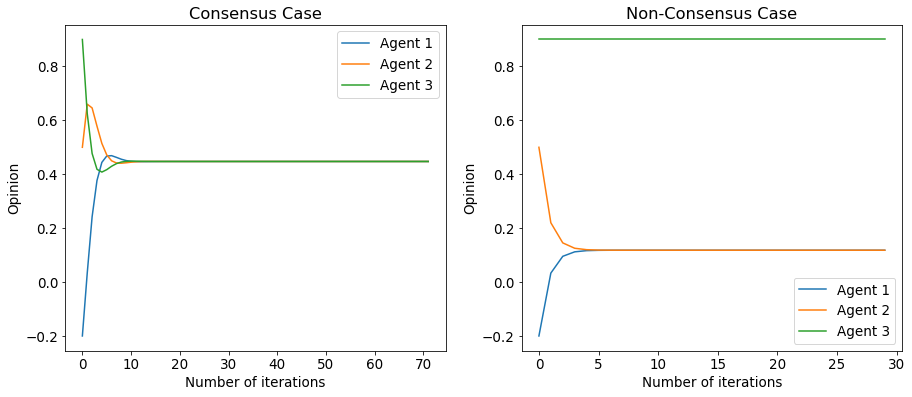

In [31]:
# Initialize opinion vector F and opinion update matrix P under two cases
F_init = np.array([-1/5, 1/2, 9/10]).T
# Consensus case
P_1 = np.array([[2/3, 1/3, 0],
               [0, 3/5, 2/5],
               [1/4, 0, 3/4]])
# Non-consensus case
P_2 = np.array([[2/3, 1/3, 0],
               [2/5, 3/5, 0],
               [0, 0, 1]])
N = 3  # Number of agents
t_max = 100  # Maximum number of iterations

# Run simulations under two cases and record the opinion vector at each iteration
F_history_1 = np.array(simulate_degroot(F_init, P_1, t_max))
F_history_2 = np.array(simulate_degroot(F_init, P_2, t_max))

# Plot the opinion evolution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
for a in range(N):
    ax[0].plot(F_history_1[:, a], label='Agent %d' % (a + 1))
    ax[1].plot(F_history_2[:, a], label='Agent %d' % (a + 1))
for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('Number of iterations')
    ax[i].set_ylabel('Opinion')
ax[0].set_title('Consensus Case')
ax[1].set_title('Non-Consensus Case');


The following assertion tests should pass if all agent opinions converge to the same value in the consensus case, and if all agent opinions do not converge to the same value in the non-consensus case.

In [32]:
assert_equal(np.all([np.isclose(F_history_1[-1, a], F_history_1[-1, 0]) for a in range(N)]), True)
assert_equal(np.all([np.isclose(F_history_2[-1, a], F_history_2[-1, 0]) for a in range(N)]), False)


#### Task 1.2: Analytical solution
Thanks to the simplicity of the DeGroot model, we can analytically solve for the opinion at convergence if a consensus is reached.

Specifically, the opinion vector at convergence is $\lim_{t\to\infty}F^{(t)}$. Since $F^{(t)}=PF^{(t-1)}=P^2F^{(t-2)}=\dots=P^{t}F^{(0)}$, $$\lim_{t\to\infty}F^{(t)}=\lim_{t\to\infty}P^tF^{(0)}.$$

If we assume a consensus of opinions at convergence, $\lim_{t\to\infty}P^t$ should have the exact same rows; or, formally, let $\pi=(\pi_0, \pi_1, \dots, \pi_N)$ be a $1\times N$ row vector, then we can write $\lim_{t\to\infty}P^t$ as
$$\lim_{t\to\infty}P^t=\begin{pmatrix}
\pi_0 & \pi_1 & \cdots & \pi_N \\
\pi_0 & \pi_1 & \cdots & \pi_N \\
\vdots & \vdots & \ddots & \vdots \\
\pi_0 & \pi_1 & \cdots & \pi_N \\
\end{pmatrix},$$
and the opinion value of consensus will just be $\pi F^{(0)}$.

It can be shown that the value of $\pi$ can be found by *solving the equation $\pi P=\pi$, subject to the constraint of $\sum_i \pi_i=1$*, when $P$ is an irreducible aperiodic stochastic matrix. We will not cover the rigorous definition of an irreducible aperiodic stochastic matrix or the proof of the statement here - read more on [stochastic matrices](https://en.wikipedia.org/wiki/Stochastic_matrix#Definition_and_properties) and [Markov chains](https://en.wikipedia.org/wiki/Markov_chain) if you are interested - but now you only need to know that an irreducible aperiodic stochastic matrix $P$ will guarantee a consensus and an analytical solution of it. 

In task 1.2, you will **implement the function for finding this analytical solution of $\pi$, given an irreducible aperiodic stochastic matrix $P$**.

Hints:
1. The eigenvalue $\lambda$ and eigenvector $v$ of a matrix $P$ satisfy $Pv=\lambda v$. Think about how you can use the eigendecomposition of $P^T$ (the transpose of $P$) to find $\pi$.
2. When comparing an eigenvalue to some constant, use for example `if abs(eigval - constant) < 1e-5`, instead of `if eigval == constant`.
3. `eigvecs[:, i]` stores the $i^{th}$ eigenvector.
4. Remember to ensure that the returned $\pi$ has entries summed up to 1.

In [33]:
def find_stationary_prob(P):
    """
    Find the stationary probability vector given the opinion update matrix
    
    Parameters:
    P - Opinion update matrix P
    
    Returns:
    Stationary probability vector pi
    """
    eigvals, eigvecs = np.linalg.eig(P.T)
    for i, val in enumerate(eigvals):
        # START 1.2
        if abs(val - 1.0) < 1e-5:  # If the eigenvalue is 1
            pi = np.real(eigvecs[:, i])  # Get the corresponding eigenvector
            pi = pi / np.sum(pi)  # Ensure that entries sum up to 1
            return pi
        # END 1.2
    return None


Now let's test your implementation with two examples from the paper. If you have implemented the function correctly, the following assertion tests should pass with no error.

In [34]:
P_1 = np.array([[1/2, 1/2],
               [1/4, 3/4]])
pi_1 = find_stationary_prob(P_1)
assert_almost_equal(pi_1, [1/3, 2/3])

P_2 = np.array([[1/2, 1/2, 0],
                 [1/4, 3/4, 0],
                 [1/3, 1/3, 1/3]])
pi_2 = find_stationary_prob(P_2)
assert_almost_equal(pi_2, [1/3, 2/3, 0])


And some other examples.

In [35]:
P_3 = np.array([[1/3, 2/3],
               [2/3, 1/3]])
pi_3 = find_stationary_prob(P_3)
assert_almost_equal(np.sum(pi_3), 1)
assert_almost_equal(pi_3 @ P_3, pi_3)

P_4 = np.array([[2/3, 1/3, 0],
               [0, 3/5, 2/5],
               [1/4, 0, 3/4]])
pi_4 = find_stationary_prob(P_4)
assert_almost_equal(np.sum(pi_4), 1)
assert_almost_equal(pi_4 @ P_4, pi_4)

P_5 = np.array([[2/3, 1/3, 0],
               [0, 3/5, 2/5],
               [0, 0, 1]])
pi_5 = find_stationary_prob(P_5)
assert_almost_equal(np.sum(pi_5), 1)
assert_almost_equal(pi_5 @ P_5, pi_5)


Finally, let's check if our analytical solution matches the simulation results!

In [36]:
F_init = np.array([-0.2, 0.5, 0.9])
P_1 = np.array([[2/3, 1/3, 0],
               [0, 3/5, 2/5],
               [1/4, 0, 3/4]])
pi = find_stationary_prob(P_1)
consensus = np.dot(pi, F_init)

for i in range(N):
    assert_almost_equal(consensus, F_history_1[-1, i])
    

### Part 2: The Attraction-Repulsion Model (Axelrod et al. '21)
The DeGroot model has the merit of allowing for an analytical solution, yet meanwhile fails to depict realistic dynamics of opinion evolution - for example, at each time step, it is very unlikely that every agent should be exposed to the opinions of all other agents and update their opinion accordingly; instead, it probably makes more sense to choose a random pair of agents for interacting.

Multiple agent-based opinion dynamics models function in this way. In part 2 of this exercise, you will implement the Attraction-Repulsion model (ARM) from [Axelrod et al.'s PNAS 2021 paper](https://www.pnas.org/doi/epdf/10.1073/pnas.2102139118).

The ARM works as follows:
1. The system is initialized with $N$ agents, each holding an opinion that is sampled uniformly from $(0.0, 1.0)$. (In the original paper, the authors actually used a normal distribution for initial opinion sampling; in this exercise we will use a uniform distribution for simplicity.)
2. At each time step, a random agent `a1` is selected to update his/her opinion. 
3. With probability $P$, `a1` changes his/her opinion to be his/her initial opinion (therefore $P$ is called the self-interest parameter). Otherwise, `a1` selects another agent `a2` at random for potential interaction. If so, `a1` decides to interact with `a2` with probability $(1/2)^{d/E}$, where $d$ is the distance (or difference) between their opinions, and $E$ is the model parameter that controls agents' exposure to different opinions (the exposure parameter). Intuitively, the larger $E$ is, the higher exposure agents have to different opinions - which means they are more likely to interact with agents with different opinions.
4. If `a1` decides to interact with `a2`, there are two possible modes of interaction:
    - Attraction: If the distance $d$ between the agents' opinions is smaller than the tolerance parameter $T$, then `a1` will be attracted to `a2`, and moves his/her opinion toward `a2`'s opinion by a fraction $R$ (the responsiveness parameter). 
    - Repulsion: If the distance $d$ between the agents' opinions is larger than the tolerance parameter $T$, then `a1` will be repulsed by `a2`, and moves his/her opinion away from `a2`'s opinion by a fraction $R$.  
    *For example, assume `a1` has opinion $0.4$, `a2` has opinion $0.2$, and $R=0.5$. If $T=0.3$, then `a1` will be attracted to `a2` (because their opinion difference $d=0.2<T$), and `a1` will update his/her opinion to be $0.4+0.5\cdot(0.2-0.4)=0.3$; otherwise, if $T=0.1$, then `a1` will be repulsed by `a2` (because their opinion difference $d=0.2>T$), and `a1` will update his/her opinion to be $0.4-0.5\cdot(0.2-0.4)=0.5$.
5. Repeat 2-4.

Additionally, at a certain time step, an external shock might happen, and shift the opinions of all agents toward 1 by shock strength $\Delta$.

In the following tasks, you will first complete the code for simulating the process described above, and then explore the effect of the different parameters (tolerance $T$, responsiveness $R$, exposure $E$, self-interest $P$, shock strength $\Delta$) on the level of polarization in the system, which is measured by the variance of the agent opinions.

#### Task 2.1: Implement agent interaction 
To start with, you will complete the code for agent interactions in the ARM. We have provided most code for you, and you only need to **implement the `prob_interact` function for calculating the interaction probability, and the `opinion_attracted` and `opinion_repulsed` functions for calculating the opinion update**. Note that you don't have to implement the opinion truncation (i.e., truncating opinion values below 0 or above 1) because it is already implemented in the `agent_interaction` function.

In [37]:
class Agent:
    def __init__(self, opinion):
        if opinion < 0:
            self.opinion = 0
        elif opinion > 1:
            self.opinion = 1
        else:
            self.opinion = opinion
        self.init_opinion = self.opinion
        
        
class Grid:
    def __init__(self, n, m):
        self.n = n
        self.m = m
        self._grid = np.empty(shape=(n, m), dtype=object)
        
    def __getitem__(self, coo):
        return self._grid[coo[0], coo[1]]
    
    def __setitem__(self, coo, val):
        self._grid[coo[0], coo[1]] = val
    
    def init_agents(self, mode='uniform'):
        """
        Initialize agents on a grid with randomly sampled opinions
        
        Parameters:
        mode - Distribution to sample initial opinions from
        """
        if mode == 'normal':
            for i in range(self.n):
                for j in range(self.m):
                    self._grid[i, j] = Agent(rng.normal(0.5, 0.2))
        
        elif mode == 'uniform':
            for i in range(self.n):
                for j in range(self.m):
                    self._grid[i, j] = Agent(rng.random())
    
    def random_index(self, num):
        """
        Randomly sample agents from the system
        
        Parameters:
        num - Number of agents to sample
        
        Returns:
        List of index tuples of randomly sampled agents
        """
        indices = rng.choice(list(range(self.n * self.m)), size=num, replace=False)
        return [(idx % self.n, idx // self.n) for idx in indices]
    
    def prob_interact(self, d, E):
        """
        Calculate the probability of interaction between two agents
        
        Parameters:
        d - Distance between the two agents
        E - Exposure parameter
        
        Returns:
        Probability of interaction between the agents
        """
        # START 2.1

        return (1/2) ** (d / E)
        # END 2.1
    
    def opinion_attracted(self, a1_opinion, a2_opinion, R):
        """
        Calculate the updated opinion of a1 when a1 is attracted to a2
        
        Parameters:
        a1_opinion - Original opinion of a1
        a2_opinion - Original opinion of a2
        R - Responsiveness parameter
        
        Returns:
        Updated opinion of a1
        """
        # START 2.1
        return a1_opinion + R * (a2_opinion - a1_opinion)
        # END 2.1
    
    def opinion_repulsed(self, a1_opinion, a2_opinion, R):
        """
        Calculate the updated opinion of a1 when a1 is repulsed by a2
        
        Parameters:
        a1_opinion - Original opinion of a1
        a2_opinion - Original opinion of a2
        R - Responsiveness parameter
        
        Returns:
        Updated opinion of a1
        """
        # START 2.1
        return a1_opinion - R * (a2_opinion - a1_opinion)
        # END 2.1
    
    def agent_interaction(self, T=0.25, R=0.25, E=0.1, P=0):
        """
        Perform agent interaction
        
        Parameters:
        T - Tolerance parameter
        R - Responsiveness parameter
        E - Exposure parameter
        P - Self-interest parameter
        """
        # Select a1 and a2 at random
        indices = self.random_index(2)
        a1 = self._grid[indices[0][0], indices[0][1]]
        a2 = self._grid[indices[1][0], indices[1][1]] 
        
        a1_opinion = a1.opinion
        a2_opinion = a2.opinion
        d = abs(a1_opinion - a2_opinion)
        
        # Calculate probability of interaction
        p_interact = self.prob_interact(d, E)
        
        if rng.random() < P:
            a1.opinion = a1.init_opinion
        else:
            if rng.random() < p_interact:
                if d < T:
                    # a1 attracted to a2
                    a1_new_opinion = self.opinion_attracted(a1_opinion, a2_opinion, R)
                else:
                    # a1 repulsed by a2
                    a1_new_opinion = self.opinion_repulsed(a1_opinion, a2_opinion, R)

                # Truncate the updated opinion by boundaries
                if a1_new_opinion < 0:
                    a1.opinion = 0
                elif a1_new_opinion > 1:
                    a1.opinion = 1
                else:
                    a1.opinion = a1_new_opinion
    
    def shift_agents(self, Delta):
        """
        Shift the opinion of all agents toward 1 by Delta
        
        Parameters:
        Delta - Amount of opinion shifting
        """
        for i in range(n):
            for j in range(m):
                a = self._grid[i, j]
                a.opinion = min(a.opinion + Delta, 1)
                    
    def opinion_matrix(self):
        """
        Returns the agent opinions as a matrix
        """
        opinions = np.zeros((n, m))
        for i in range(n):
            opinions[i, :] = [self._grid[i, j].opinion for j in range(m)]
        return opinions
    
    def opinion_variance(self):
        """
        Returns the variance of agent opinions in the system
        """
        opinions = self.opinion_matrix().flatten()
        return np.var(opinions)     


Let's first test if you have implemented the functions correctly. If so, the following assertion tests should pass with no error.

In [38]:
test_grid = Grid(10, 10)

# Test the prob_interact function
assert_almost_equal(test_grid.prob_interact(0.2, 0.2), 0.5)
assert_almost_equal(test_grid.prob_interact(0.5, 0.25), 0.25)

# Test the opinion_attracted function
assert_almost_equal(test_grid.opinion_attracted(0.4, 0.2, 0.5), 0.3)
assert_almost_equal(test_grid.opinion_attracted(0.1, 0.6, 0.2), 0.2)

# Test the opinion_repulsed function
assert_almost_equal(test_grid.opinion_repulsed(0.4, 0.2, 0.5), 0.5)
assert_almost_equal(test_grid.opinion_repulsed(0.1, 0.6, 0.2), 0)


Now let's try to perform a full run of the simulation. After the simulation ends, you should be able to see the visualized opinion matrices at the beginning and the end of the simulation - the opinions should be uniformly distributed at $t=0$, and become almost fully polarized at $t=1000000$.

The code below takes ~30 seconds to run in our testing environment. If you are not sure how fast it runs in your environment, you can first try cutting the number of time steps to for example 1/10 of the original value, to get an estimate of the running time. Let us know if it takes (or is estimated to take) very long time to run the code in your environment.

Opinion variance after 100000 iterations: 0.11
Runtime: 3s


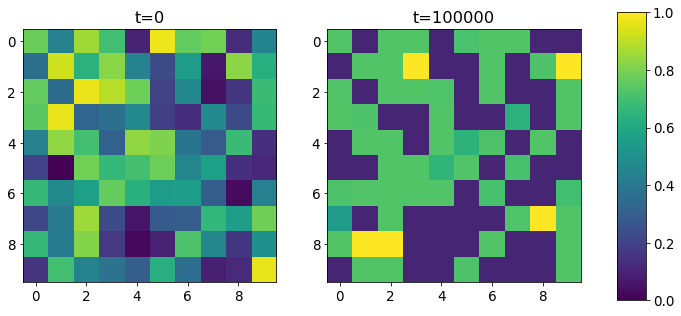

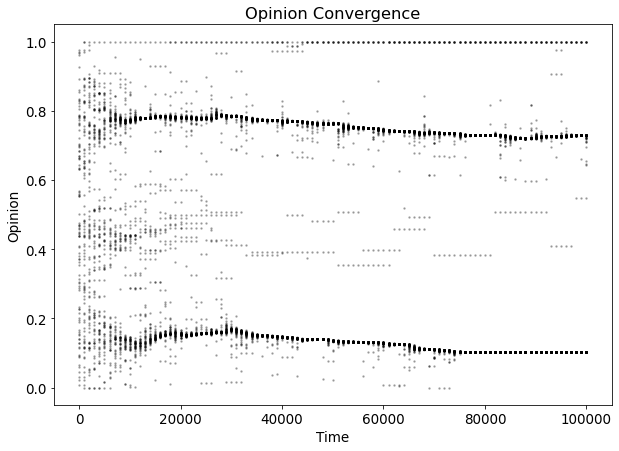

In [39]:
rng = np.random.default_rng(42)
start_time = time.time()

# Set parameters
# T = 0.1 # opinion variance 0.22
# T = 0.3 # opinion variance 0.24
# T = 0.5 # opinion variance 0.00
# T = 0.7 # opinion variance 0.00

T = 0.2
R = 0.25 
R = 0.45
E = 0.05
P = 0
n = 10
m = 10
init_mode = 'uniform'
t_max = 100000

# Create grid and initialize agents
grid = Grid(n, m)
grid.init_agents(mode=init_mode)

# Visualize opinion matrix before the interactions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
norm = plt.Normalize(0, 1)
ax[0].imshow(grid.opinion_matrix(), norm=norm)
ax[0].set_title('t=0')

# Perform agent interactions
opinion_history = [grid.opinion_matrix().flatten()]
for t in range(t_max // 1000):
    for _ in range(1000):
        grid.agent_interaction(T=T, R=R, E=E, P=P)
    opinion_history.append(grid.opinion_matrix().flatten())

# Visualize opinion matrix after the interactions 
im = ax[1].imshow(grid.opinion_matrix(), norm=norm)
ax[1].set_title('t=%d' % t_max)
cax = plt.axes([0.95, 0.1, 0.04, 0.8])
plt.colorbar(im, cax=cax)

# Visualize opinion convergence
opinion_history = np.array(opinion_history)
fig2, ax2 = plt.subplots(figsize=(10, 7))
for i in range(n * m):
    ax2.plot(list(range(t_max // 1000 + 1)), opinion_history[:, i], 'k.', alpha=0.25, markersize=3)
ax2.set_xticks([s * (t_max // 5000) for s in range(6)])
ax2.set_xticklabels([s * (t_max // 5) for s in range(6)])
ax2.set_xlabel('Time')
ax2.set_ylabel('Opinion')
ax2.set_title('Opinion Convergence')

end_time = time.time()

# Print opinion variance in the final status
print('Opinion variance after %d iterations: %.2f' % (t_max, grid.opinion_variance()))
print('Runtime: %ds' % (end_time - start_time))


#### Task 2.2: Parameter space analysis
In task 2.2, you will explore how the different model parameters affect the level of polarization in the system. Basically, to analyze each parameter (or parameter combination), you will have the other parameters fixed, and run simulations under different settings of the target parameter(s). We provide you the code for running a single simulation as follows.

In [40]:
def run_model(T, R, E, P, n, m, t_max):
    """
    Runs a single simulation of the model under the given parameter settings
    
    Parameters:
    T - Tolerance parameter
    R - Responsiveness parameter
    E - Exposure parameter
    P - Self-interest parameter
    n - Height of grid
    m - Width of grid
    t_max - Maximum number of time steps
    
    Returns:
    List of opinion variance at each time step
    """
    variances = []
    grid = Grid(n, m)
    grid.init_agents(mode='uniform')
    for t in range(t_max):
        grid.agent_interaction(T=T, R=R, E=E, P=P)
        variances.append(grid.opinion_variance())
    return variances


##### a) Tolerance
Let's start by analyzing the tolerance parameter $T$. To see the different levels of polarization driven by different $T$ values, you need to plot the curves of opinion variance evolution under different $T$ settings. Here, we provide you the code for plotting a single curve; you need to **extend it to plot multiple curves, each corresponding to one candidate value of $T$**. Then, use this code to **answer question 2.2.1 (Tolerance) on A+, where you will be given the list of candidate values to explore**.

The code below takes ~1.6 minutes to run in our testing environment.

Runtime: 0.3 minutes


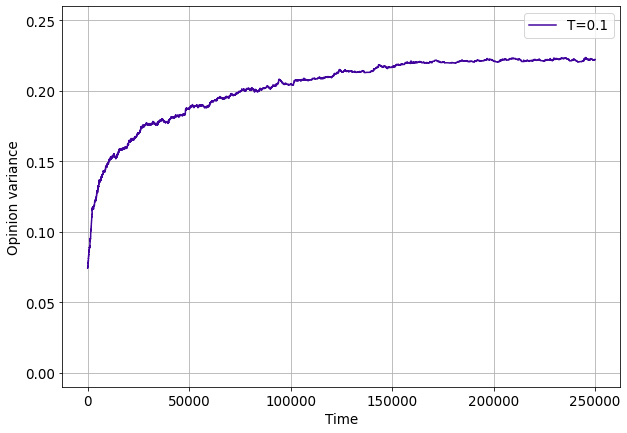

In [41]:
rng = np.random.default_rng(42)
start_time = time.time()

def plot_curve(T, R, E, P, n, m, t_max, ax):
    variances = run_model(T=T, R=R, E=E, P=P, n=n, m=m, t_max=t_max) 
    cmap = plt.get_cmap('plasma')
    ax.plot(variances, '-', color=cmap(T), label=('T=%.1f' % T)) 

fig, ax = plt.subplots(figsize=(10, 7))

# START 2.2a
plot_curve(T=0.1, R=0.25, E=0.1, P=0., n=10, m=10, t_max=250000, ax=ax)
# END 2.2a

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Opinion variance')
ax.set_ylim(-0.01, 0.26)
ax.grid(True)

end_time = time.time()
print('Runtime: %.1f minutes' % ((end_time - start_time) / 60))


##### b) Responsiveness
With the responsiveness parameter $R$, we want to do something slightly different - we want to see the joint effect of responsiveness $R$ and tolerance $T$ on the system. To do so, we will plot a heatmap of a $6\times 6$ grid, where the color of each cell shows the average opinion variance (at the end of the simulation) across 5 different runs under this parameter combination. 

We have done the plotting for you because it takes quite some time to run this code. Use the results to **answer question 2.2.2 (Responsiveness) on A+**.

Runtime: 14.1 minutes


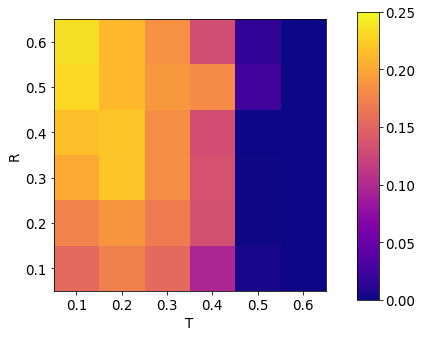

In [42]:
rng = np.random.default_rng(42)

R_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
T_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

variances = np.zeros((len(R_range), len(T_range)))
n_samples = 5

start_time = time.time()
for i, R in enumerate(R_range):
    for j, T in enumerate(T_range):
        variances_samples = []
        for _ in range(n_samples):
            v = run_model(T=T, R=R, E=0.1, P=0., n=10, m=10, t_max=50000)
            variances_samples.append(v[-1])           
        variances[len(R_range) - 1 - i, j] = np.mean(variances_samples)

# Plot the heatmap of results
fig, ax = plt.subplots(figsize=(6, 5))
norm = plt.Normalize(0, 0.25)
im = ax.imshow(variances, cmap='plasma', norm=norm)
ax.set_xlabel('T')
ax.set_xticks(range(len(T_range)))
ax.set_xticklabels(["{:,.1f}".format(T) for T in T_range])
ax.set_ylabel('R')
ax.set_yticks(range(len(R_range)))
ax.set_yticklabels(reversed(["{:,.1f}".format(R) for R in R_range]))

cax = plt.axes([0.9, 0.1, 0.05, 0.8])
plt.colorbar(im, cax=cax)

end_time = time.time()
print('Runtime: %.1f minutes' % ((end_time - start_time) / 60))


##### c) Exposure
Next, we will analyze the exposure parameter $E$. As in 2.2a, you need to **extend the code to plot multiple opinion variance curves, each corresponding to one candidate value of $E$**. Then, use this code to **answer question 2.2.3 (Exposure) on A+, where you will be given the list of candidate values to explore**.

The code below takes ~0.8 minutes to run in our testing environment.

Runtime: 0.1 minutes


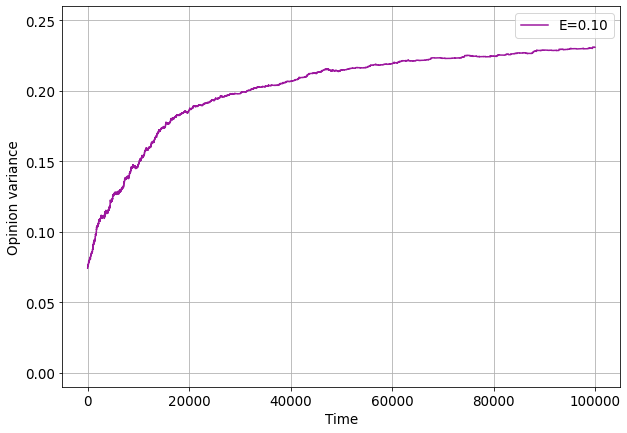

In [43]:
rng = np.random.default_rng(42)
start_time = time.time()

def plot_curve(T, R, E, P, n, m, t_max, ax):
    variances = run_model(T=T, R=R, E=E, P=P, n=n, m=m, t_max=t_max)
    cmap = plt.get_cmap('plasma')
    ax.plot(variances, '-', color=cmap(E / 0.3), label=('E=%.2f' % E))

fig, ax = plt.subplots(figsize=(10, 7))

# START 2.2c
plot_curve(T=0.2, R=0.25, E=0.1, P=0., n=10, m=10, t_max=100000, ax=ax)
# END 2.2c

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Opinion variance')
ax.set_ylim(-0.01, 0.26)
ax.grid(True)

end_time = time.time()
print('Runtime: %.1f minutes' % ((end_time - start_time) / 60))


##### d) Self-interest
Similarly, we will then analyze the self-interest parameter $P$. You need to **extend the code to plot multiple opinion variance curves, each corresponding to one candidate value of $P$**. Then, use this code to **answer question 2.2.4 (Self-interest) on A+, where you will be given the list of candidate values to explore**.

The code below takes ~2.0 minutes to run in our testing environment.

Runtime: 1.9 minutes


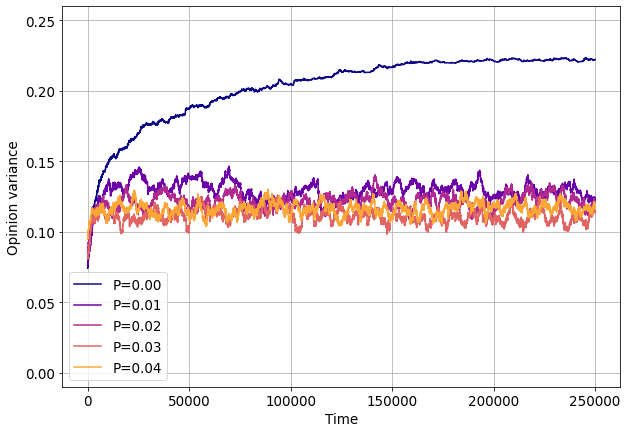

In [48]:
rng = np.random.default_rng(42)
start_time = time.time()

def plot_curve(T, R, E, P, n, m, t_max, ax):
    variances = run_model(T=T, R=R, E=E, P=P, n=n, m=m, t_max=t_max)
    cmap = plt.get_cmap('plasma')
    ax.plot(variances, '-', color=cmap(P / 0.05), label=('P=%.2f' % P))

fig, ax = plt.subplots(figsize=(10, 7))

# START 2.2d
plot_curve(T=0.1, R=0.25, E=0.1, P=0.00, n=10, m=10, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0.01, n=10, m=10, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0.02, n=10, m=10, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0.03, n=10, m=10, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0.04, n=10, m=10, t_max=250000, ax=ax)
# END 2.2d

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Opinion variance')
ax.set_ylim(-0.01, 0.26)
ax.grid(True)

end_time = time.time()
print('Runtime: %.1f minutes' % ((end_time - start_time) / 60))


##### e) External shock
Finally, we will analyze the effect of an external shock. First of all, you need to **implement the external shock event** in the `run_model_shock` function. Specifically, the missing code should call the `shift_agents` function with parameter `Delta` when the current time equals `t_shock`.

In [50]:
def run_model_shock(T, R, E, P, n, m, Delta, t_shock, t_max):
    """
    Runs a single simulation of the model with an external shock
    
    (Extra) Parameters:
    Delta - Shock strength
    t_shock - Shock time
    
    Returns:
    List of opinion variance at each time step
    """
    variances = []
    grid = Grid(n, m)
    grid.init_agents(mode='uniform')
    for t in range(t_max):
        grid.agent_interaction(T=T, R=R, E=E, P=P)
        # START 2.2e
        if t == t_shock:
            grid.shift_agents(Delta=Delta)
        # END 2.2e
        variances.append(grid.opinion_variance())
    return variances


Now, as in previous tasks, you need to **extend the code to plot multiple opinion variance curves, each corresponding to one candidate value of $\Delta$**. Then, use this code to **answer question 2.2.5 (External shock) on A+, where you will be given the list of candidate values to explore**.

The code below takes ~2.0 minutes to run in our testing environment.

Runtime: 1.8 minutes


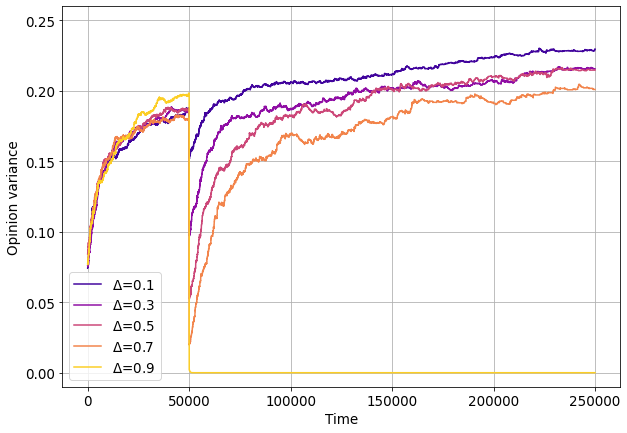

In [51]:
rng = np.random.default_rng(42)
start_time = time.time()

def plot_curve(T, R, E, P, n, m, Delta, t_shock, t_max, ax):
    variances = run_model_shock(T=T, R=R, E=E, P=P, n=n, m=m, Delta=Delta, t_shock=t_shock, t_max=t_max)
    cmap = plt.get_cmap('plasma')
    ax.plot(variances, '-', color=cmap(Delta), label=(r'$\Delta$=%.1f' % Delta))
        
fig, ax = plt.subplots(figsize=(10, 7))

# START 2.2e
plot_curve(T=0.1, R=0.25, E=0.1, P=0., n=10, m=10, Delta=0.1, t_shock=50000, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0., n=10, m=10, Delta=0.3, t_shock=50000, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0., n=10, m=10, Delta=0.5, t_shock=50000, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0., n=10, m=10, Delta=0.7, t_shock=50000, t_max=250000, ax=ax)
plot_curve(T=0.1, R=0.25, E=0.1, P=0., n=10, m=10, Delta=0.9, t_shock=50000, t_max=250000, ax=ax)
# END 2.2e
        
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Opinion variance')
ax.set_ylim(-0.01, 0.26)
ax.grid(True)

end_time = time.time()
print('Runtime: %.1f minutes' % ((end_time - start_time) / 60))


Just in case you are interested, the following code will plot the opinion distributions before/after shock and at the end of the simulation, respectively under the setting of $\Delta=0.1$ and $\Delta=0.9$. This might help you understand intuitively how the external shock affects the opinions of the agents.

The code below takes ~0.2 minutes to run in our testing environment.

Runtime: 0.3 minutes


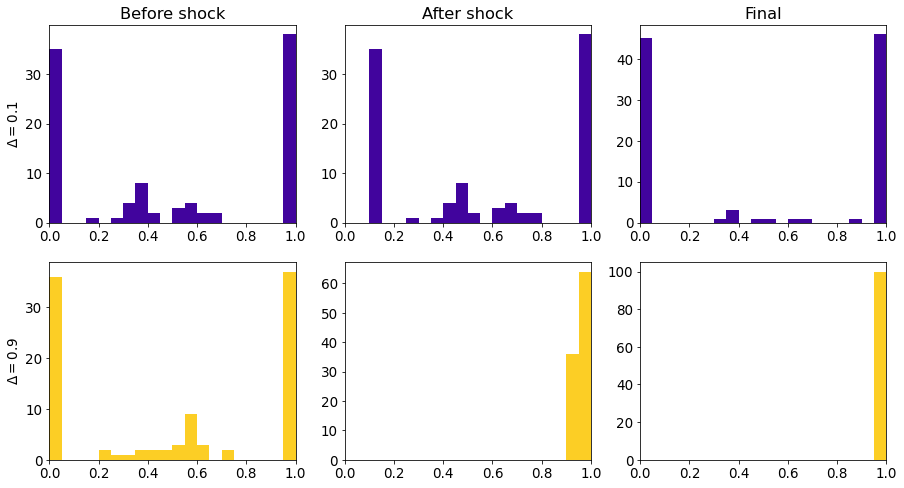

In [47]:
rng = np.random.default_rng(42)

Delta_vals = [0.1, 0.9]
T = 0.1
R = 0.25
E = 0.1
P = 0.
t_shock = 50000
t_max = 250000

start_time = time.time()
fig, ax = plt.subplots(nrows=len(Delta_vals), ncols=3, figsize=(15, 8))
cmap = plt.get_cmap('plasma')
for i, Delta in enumerate(Delta_vals):
    grid = Grid(n, m)
    grid.init_agents(mode='uniform')
    for t in range(t_max):
        grid.agent_interaction(T=T, R=R, E=E, P=P)
        if t == t_shock:
            ax[i, 0].hist(grid.opinion_matrix().flatten(), color=cmap(Delta), bins=20, range=(0, 1))
            ax[i, 0].set_xlim(0, 1)
            
            grid.shift_agents(Delta)
            
            ax[i, 1].hist(grid.opinion_matrix().flatten(), color=cmap(Delta), bins=20, range=(0, 1))
            ax[i, 1].set_xlim(0, 1)
    ax[i, 2].hist(grid.opinion_matrix().flatten(), color=cmap(Delta), bins=20, range=(0, 1))
    ax[i, 2].set_xlim(0, 1)
    
ax[0, 0].set_title('Before shock')
ax[0, 1].set_title('After shock')
ax[0, 2].set_title('Final')
ax[0, 0].set_ylabel(r'$\Delta=0.1$')
ax[1, 0].set_ylabel(r'$\Delta=0.9$')

end_time = time.time()
print('Runtime: %.1f minutes' % ((end_time - start_time) / 60))
